# Exercise 3: MAP Classifier

In this assignment you will implement a few of the MAP classifiers learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this part of the exercise.
2. Write vectorized code whenever possible.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. 
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install. Changes of the configuration we provided are at your own risk. Code that cannot run will also earn you the grade of 0.
7. Write your own code. Cheating will not be tolerated. 
8. Submission includes this notebook and the answers to the theoretical part. Answers to qualitative questions should be written in markdown cells (with $\LaTeX$ support).
9. You can add additional functions.
10. Submission: zip only the completed jupyter notebook and the PDF with your solution for the theory part. Do not include the data or any directories. Name the file `ID1_ID2.zip` and submit **only one copy of the assignment**.

## In this exercise you will perform the following:
1. Implement a Naive Bayeas Classifier based on Multi Normal distribution
1. Implement a Full Bayes Classifier based on Multi-Normal distribution
1. Implement a Distcrete Naive Bayes Classifier.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Normal Naive Bayes Classifier Vs Normal Full Bayes Classifier
In the following section we are going to compare 2 models on a given dataset. <br>
The 2 classifiers we are going to test are:
1. Naive Bayes classifer.<br>
1. Full Bayes classifier.<br>
Recall that a Naive Bayes classifier makes the following assumption :<br> 
## $$ p(x_1, x_2, ..., x_n|A_j) = \Pi p(x_i | A_j) $$
But the full Bayes classifier will not make this assumption.<br>

### The Data Story

In a faraway land called **Randomistan** there is a rare animal called the **Randomammal**.<br> 
We have gathered data about this unique animal to help the **randomian** researchers in observing this beast. <br>
For a 1000 days straight we have measured the temperature and the humidity in Randomistan and whether the Randomammal was spotted or not. <br>
The well known randomian **Bob** is a bit of a lazy researcher so he likes to keep things simple, and so he assumes that the temperature and the humidity are independent given the class. <br>
**Alice** on the other hand is a hard working researcher and does not make any assumptions, she's young and is trying to gain some fame in the randomian community.

The dataset contains 2 features (**Temperature**, **Humidity**) alongside a binary label (**Spotted**) for each instance.<br>

We are going to test 2 different classifiers :
* Naive Bayes Classifier (Bob)
* Full Bayes Classifier. (Alice)

Both of our researchers assume that our features are normally distributed. But while Bob with his Naive classifier will assume that the features are independent, Alice and her Full Bayes classifier will not make this assumption.<br><br>
Let's start off by loading the data (train, test) into a pandas dataframe and then converting them
into numpy arrays.<br>
The datafiles are :
- randomammal_train.csv
- randomammal_test.csv

In [15]:
# Load the train and test set into a pandas dataframe and convert them into a numpy array.
train_set = pd.read_csv('data/randomammal_train.csv').values
test_set = pd.read_csv('data/randomammal_test.csv').values

# Data Visualization
Draw a scatter plot of the training data where __x__=Temerature and **y**=Humidity. <br>
Use color to distinguish points from different classes.<br>
Stop for a minute to think about Alice and Bob's approaches and which one you expect to work better.

## Bob's Naive Model

Start with implementing the [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) probability density function in the next cell: 
$$ \frac{1}{\sqrt{2\pi \sigma^2}} \cdot e ^{-\frac{(x - \mu)^2}{2\sigma^2}} $$
Where :
* $\mu$ is the distribution mean.
* $\sigma$ is the distribution standard deviation.

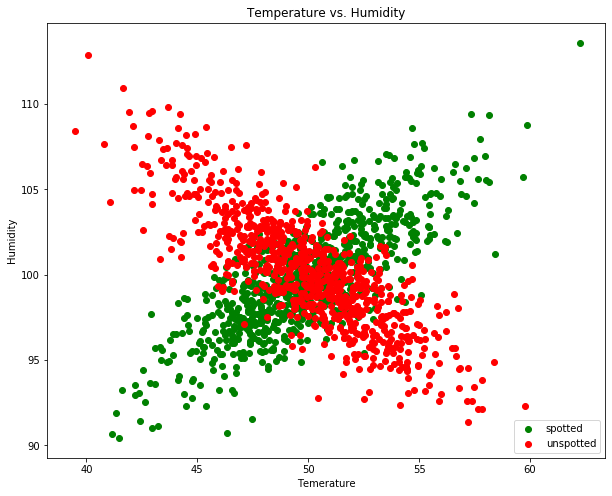

In [16]:
# Your code goes here.
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

spotted = []
unspotted = []

spotted = list(filter(lambda x: x[-1] == 1, train_set))
unspotted = list(filter(lambda x: x[-1] == 0, train_set))

plt.title('Temperature vs. Humidity')
plt.xscale('linear')
plt.xlabel('Temerature')
plt.ylabel('Humidity')

spotted = np.array(spotted)
unspotted = np.array(unspotted)

plt.scatter(spotted[:,0], spotted[:,1], c="green", label="spotted")
plt.scatter(unspotted[:,0], unspotted[:,1], c="red", label="unspotted")
plt.legend()

plt.show()

Recall that when using the naive assumption, we assume our features are indepenent given the class. Meaning:
$$ P(x_1, x_2 | Y) = p(x_1 | Y) \cdot p(x_2 | Y)$$


Since we assume our features are normally distributed we need to find the mean and std for each feature in order for us to compute those probabilites. Implement the **NaiveNormalClassDistribution** in the next cell and build a distribution object for each class.

In [17]:
def normal_pdf(x, mean, std):
    """
    Calculate normal desnity function for a given x, mean and standrad deviation.
 
    Input:
    - x: A value we want to compute the distribution for.
    - mean: The mean value of the distribution.
    - std:  The standard deviation of the distribution.
 
    Returns the normal distribution pdf according to the given mean and var for the given x.    
    """
    a = 1 / np.sqrt(2 * np.pi * np.square(std))
    b = np.exp(-1 * np.square(x - mean) / (2 * np.square(std)))

    return a * b
    pass

class NaiveNormalClassDistribution():
    def __init__(self, dataset, class_value):
        """
        A class which encapsulate the relevant parameters(mean, std) for a class conditinoal normal distribution.
        The mean and std are computed from a given data set.
        
        Input
        - dataset: The dataset as a numpy array
        - class_value : The class to calculate the parameters for.
        """
        self.class_col = dataset[:, -1]
        self.class_value = class_value

        class_data = dataset[dataset[:, -1] == class_value][:, :-1]
        self.mean = np.mean(class_data, axis=0)
        self.std = np.std(class_data, axis=0)
        pass
    
    def get_prior(self):
        """
        Returns the prior porbability of the class according to the dataset distribution.
        """
        unique, counts = np.unique(self.class_col, return_counts=True)
        stats = dict(zip(unique, counts))

        return stats[self.class_value] / sum(stats.values())
    
    def get_instance_likelihood(self, x):
        """
        Returns the likelihhod porbability of the instance under the class according to the dataset distribution.
        """
        return np.prod(normal_pdf(x, self.mean, self.std))
    
    def get_instance_posterior(self, x):
        """
        Returns the posterior porbability of the instance under the class according to the dataset distribution.
        * Ignoring p(x)
        """
        return self.get_instance_likelihood(x) * self.get_prior()

In [18]:
# Build the a NaiveNormalClassDistribution for each class.
naive_normal_CD_0 = NaiveNormalClassDistribution(train_set, 0)
naive_normal_CD_1 = NaiveNormalClassDistribution(train_set, 1)

Implement the **MAPClassifier** class and build a MAPClassifier object contating the 2 distribution objects you just made above.

In [19]:
class MAPClassifier():
    def __init__(self, ccd0 , ccd1):
        """
        A Maximum a postreiori classifier. 
        This class will hold 2 class distributions, one for class 0 and one for class 1, and will predicit an instance
        by the class that outputs the highest posterior probability for the given instance.
    
        Input
            - ccd0 : An object contating the relevant parameters and methods for the distribution of class 0.
            - ccd1 : An object contating the relevant parameters and methods for the distribution of class 1.
        """
        self.ccd0 = ccd0
        self.ccd1 = ccd1
        pass
    
    def predict(self, x):
        """
        Predicts the instance class using the 2 distribution objects given in the object constructor.
    
        Input
            - An instance to predict.
        Output
            - 0 if the posterior probability of class 0 is higher and 1 otherwise.
        """
        posterior0 = self.ccd0.get_instance_posterior(x)
        posterior1 = self.ccd1.get_instance_posterior(x)
        return 0 if posterior0 > posterior1 else 1
        pass



In [20]:
naive_normal_classifier = MAPClassifier(naive_normal_CD_0, naive_normal_CD_1)

### Evaluate model
Implement the **compute_accuracy** function in the next cell. Use it and the 2 distribution objects you created to compute the accuracy on the test set.

In [21]:
def compute_accuracy(testset, map_classifier):
    """
    Compute the accuracy of a given a testset using a MAP classifier object.
    
    Input
        - testset: The testset for which to compute the accuracy (Numpy array).
        - map_classifier : A MAPClassifier object capable of prediciting the class for each instance in the testset.
        
    Ouput
        - Accuracy = #Correctly Classified / #testset size
    """
    correctly_classified = 0
    for instance in testset:
        # Predict instance classification without including it's classifier value
        result = map_classifier.predict(instance[:-1])
        if result == instance[-1]:
            correctly_classified += 1

    return correctly_classified / len(testset)

In [22]:
# Compute the naive model accuracy and store it in the naive accuracy variable.
naive_accuracy = compute_accuracy(test_set, naive_normal_classifier)
naive_accuracy

0.495

## Alice's Full Model

Start with Implementing the [multivariate normal](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) distribution probability density function in the next cell.

## $$ (2\pi)^{-\frac{d}{2}} det(\Sigma )^{-\frac{1}{2}} \cdot e ^{-\frac{1}{2}(x-\mu)^T \Sigma ^ {-1} (x - \mu) }$$

Where : 
* $\mu$ is the distribution mean vector. (length 2 in our case)
* $\Sigma$ Is the distribution covarince matrix. (size 2x2 in our case)

In the full bayes model we will not make any simplyfing assumptions, meaning, we will use a multivariate normal distribution. <br>
And so, we'll need to compute the mean of each feature and to compute the covariance between the features to build the covariance matrix.
Implement the **MultiNormalClassDistribution** and build a distribution object for each class.

In [23]:
def multi_normal_pdf(x, mean, cov):
    """
    Calculate multi variable normal desnity function for a given x, mean and covarince matrix.
 
    Input:
    - x: A value we want to compute the distribution for.
    - mean: The mean value of the distribution.
    - std:  The standard deviation of the distribution.
 
    Returns the normal distribution pdf according to the given mean and var for the given x.    
    """
    a = np.power(2 * np.pi, (-1) * len(mean) / 2) * np.power(np.linalg.det(cov), -0.5)
    b = np.exp(-0.5 * np.dot(np.dot((x - mean).T, np.linalg.inv(cov)), (x - mean)))

    return a * b
    pass

class MultiNormalClassDistribution():
    def __init__(self, dataset, class_value):
        """
        A class which encapsulate the relevant parameters(mean, cov matrix) for a class conditinoal multi normal distribution.
        The mean and cov matrix (You can use np.cov for this!) will be computed from a given data set.
        
        Input
        - dataset: The dataset as a numpy array
        - class_value : The class to calculate the parameters for.
        """
        class_data = dataset[dataset[:, -1] == class_value][:, :-1]
        self.mean = np.mean(class_data, axis=0)
        self.class_col = dataset[:, -1]
        self.class_value = class_value
        self.cov = np.cov(class_data.T)
        
    def get_prior(self):
        """
        Returns the prior porbability of the class according to the dataset distribution.
        """
        unique, counts = np.unique(self.class_col, return_counts=True)
        stats = dict(zip(unique, counts))
        return stats[self.class_value] / sum(stats.values())
    
    def get_instance_likelihood(self, x):
        """
        Returns the likelihood of the instance under the class according to the dataset distribution.
        """
        return multi_normal_pdf(x, self.mean, self.cov)
    
    def get_instance_posterior(self, x):
        """
        Returns the posterior porbability of the instance under the class according to the dataset distribution.
        * Ignoring p(x)
        """
        return self.get_instance_likelihood(x) * self.get_prior()

In [24]:
# Build the a MultiNormalClassDistribution for each class.
multi_normal_CD_0 = MultiNormalClassDistribution(train_set, 0)
multi_normal_CD_1 = MultiNormalClassDistribution(train_set, 1)

build a MAPClassifier object contating the 2 distribution objects you just made above.

In [25]:
multi_normal_classifier = MAPClassifier(multi_normal_CD_0, multi_normal_CD_1)

### Evaluate model
Use the **compute_accuracy** function and the 2 distribution objects you created to compute the accuracy on the test set.

In [26]:
# Compute the naive model accuracy and store it in the naive accuracy variable.
full_accuracy = compute_accuracy(test_set, multi_normal_classifier)
full_accuracy

0.7975

## Results

Use a plot bar to showcase the models accuracy.

Text(0, 0.5, 'Accuracy')

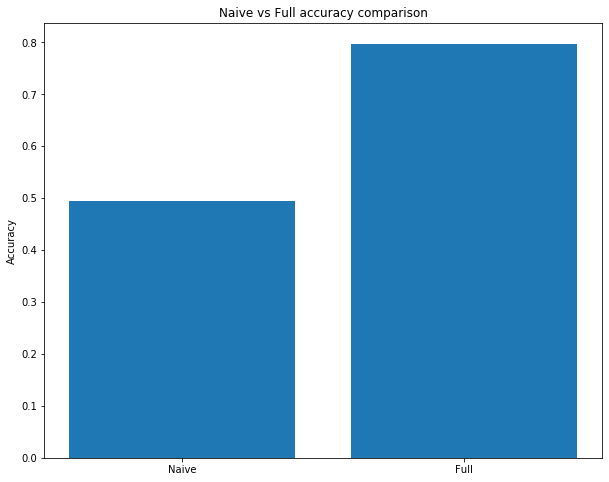

In [27]:
# Bar plot of accuracy of each model side by side.
plt.bar(x=['Naive', 'Full'], height=[naive_accuracy, full_accuracy])
plt.title("Naive vs Full accuracy comparison")
plt.ylabel("Accuracy")

# Discrete Naive Bayes Classifier 

We will now build a discrete naive Bayes based classifier using **Laplace** smoothing.
In the recitation, we saw how to compute the probability for each attribute value under each class:

$$ P(x_j | A_i) = \frac{n_{ij} + 1}{n_i + |V_j|} $$
Where:
* $n_{ij}$ The number of training instances with the class $A_i$ and the value $x_j$ in the relevant attribute.
* $n_i$ The number of training instances with the class $A_i$
* $|V_j|$ The number of possible values of the relevant attribute.

In order to compute the likelihood we assume:
$$ P(x| A_i) = \prod\limits_{j=1}^{n}P(x_j|A_i) $$

And to classify an instance we will choose : 
$$\arg\!\max\limits_{i} P(A_i) \cdot P(x | A_i)$$


## Data
We will try to predict breast cancer again only this time from a different dataset, 
<br> you can read about the dataset here : [Breast Cancer Dataset](https://archive.ics.uci.edu/ml/datasets/breast+cancer)<br>
Load the training set and test set provided for you in the data folder.
 - breast_trainset.csv
 - breast_testset.csv
 

In [28]:
# Load the train and test set into a pandas dataframe and convert them into a numpy array.
train_set = pd.read_csv('data/breast_trainset.csv').values
test_set = pd.read_csv('data/breast_testset.csv').values

## Build A Discrete Naive Bayes Distribution for each class
Implement the **DiscreteNBClassDistribution** in the next cell and build a distribution object for each class.

In [29]:
EPSILLON = 1e-6 # if a certain value only occurs in the test set, the probability for that value will be EPSILLON.

class DiscreteNBClassDistribution():
    def __init__(self, dataset, class_value):
        """
        A class which computes and encapsulate the relevant probabilites for a discrete naive bayes 
        distribution for a specific class. The probabilites are computed with laplace smoothing.
        
        Input
        - dataset: The dataset as a numpy array.
        - class_value: Compute the relevant parameters only for instances from the given class.
        """
        self.total_len = len(dataset)
        self.class_value = class_value
        self.class_data = dataset[dataset[:, -1] == class_value][:, :-1]
        
        # Determines the number of possible values of the relevant attribute
        self.vj = []

        # Determines the number of training instances with the given class
        self.ni = len(self.class_data)

        for col in dataset.T:
            self.vj.append(len(np.unique(col)))
            
        pass
    
    def get_prior(self):
        """
        Returns the prior porbability of the class according to the dataset distribution.
        """
        return self.ni / self.total_len
    
    def get_instance_likelihood(self, x):
        """
        Returns the likelihood of the instance under the class according to the dataset distribution.
        """
        result = 1

        # Iterate each attribute to calculate the likelihood.
        for idx, elem in enumerate(x):
            col = self.class_data[:, idx]
            nij = sum(col == x[idx]) if elem in col else EPSILLON
            probability = (nij + 1) / (self.ni + self.vj[idx])

            # Assume independence between attributes.
            result *= probability

        return result
    
    def get_instance_posterior(self, x):
        """
        Returns the posterior porbability of the instance under the class according to the dataset distribution.
        * Ignoring p(x)
        """
        return self.get_prior() * self.get_instance_likelihood(x)

In [30]:
discrete_naive_CD_0 = DiscreteNBClassDistribution(train_set, 0)
discrete_naive_CD_1 = DiscreteNBClassDistribution(train_set, 1)

build a MAPClassifier object contating the 2 distribution objects you just made above.

In [31]:
discrete_naive_classifier = MAPClassifier(discrete_naive_CD_0, discrete_naive_CD_1)

Use the **compute_accuracy** function and the 2 distribution objects you created to compute the accuracy on the test set.

In [32]:
compute_accuracy(test_set, discrete_naive_classifier)

0.7368421052631579